# Homework5: Denoising Diffusion Probabilistic Model (DDPM)

## Task 1: Theory (5pt)

### Problem 1: Gaussian Diffusion (2pt)

In the course we have discussed two types of Gaussian diffusions:
- $\mathbf{x}_t = \mathbf{x}_0 + \sigma_t \cdot \boldsymbol{\epsilon}$ - score-based models,
- $\mathbf{x}_t = \sqrt{1 - \beta_t} \cdot \mathbf{x}_{t-1} + \sqrt{\beta_t} \cdot \boldsymbol{\epsilon}$ - diffusion models.

**Part 1.** Let consider the single step Markov chain $q(\mathbf{x}_t | \mathbf{x}_{t-1}) = \mathcal{N}(a \cdot \mathbf{x}_{t-1}, b^2 \cdot \mathbf{I})$. We can choose $a$ and $b$ such that the distribution of $\mathbf{x}_{\infty}$ has the identity covariance matrix. Such a process is called *Variance Preserving*. Prove that for this property to hold, it is necessary that:
$$
a = \sqrt{\alpha}; \quad b = \sqrt{1 − \alpha}.
$$


**Part 2.** One may ask: "Why we do not consider the more general diffusion models?". This was exactly the idea of the paper [Variational Diffusion Models](https://arxiv.org/abs/2107.00630).

Let consider the diffusion of the form
$$
    \mathbf{x}_t = \alpha_t \cdot \mathbf{x}_0 + \sigma_t \cdot \boldsymbol{\epsilon}, \quad \mathbf{x}_t \sim q(\mathbf{x}_t | \mathbf{x}_0) = \mathcal{N}(\alpha_t \cdot \mathbf{x}_0, \sigma_t^2 \cdot \mathbf{I}).
$$

Find the distribution $q(\mathbf{x}_t | \mathbf{x}_s)$ for $s < t$ (you have to derive the formulas for mean $\alpha_{t|s}$ and variance $\sigma_{t|s}$).

```
your solution
```

### Problem 2: Strided sampling (2pt)

Sampling from DDPM is very slow.  There are several techniques to alleviate this drawback.
In this task we are going to investigate one of them.

Assume we have already trained a model $p(\mathbf{x}_{t - 1} | \mathbf{x}_t, \boldsymbol{\theta})$ to "reverse" a Markov chain of length $T$. Let's try to build inference process using subsequence of timesteps $\{S_0 = 0, S_1, \ldots, S_{T'-1}, S_{T'} = T\}$, where $T' < T$. Using this subsequence we have to do $T'$ inference steps instead of $T$. It could dramatically reduce inference time.

You goal is to find the expression for the iterative update in this case (how to get $\mathbf{x}_{S_{t-1}}$ from $\mathbf{x}_{S_t}$).

```
your solution
```

### Problem 3: Tweedie’s formula (1 pt)

Consider a Wiener process $dX=\sigma\,dW$ initiated from a distribution $p_0(x)$. Now recall that if we run the given Wiener process for a duration $\delta>0$ we have  

$$
    X_\delta = X_0 + \mathcal{N}(0,\sigma^{2}\delta),
$$

where $X_0 \sim p_0(x)$.

We know that the reverse dynamics are given by $d\bar{X}=\sigma^{2}\nabla\log p_t(\bar{X})\,dt + \sigma\,d\bar{W}$. Thus, fixing some $y = X_\delta$ for small $\delta$, the following approximation will hold true:

$$
    \mathbb{E}\!\left[X_0 \mid X_\delta = y\right] \approx y + \nabla\log p_\delta(y)\,\sigma^{2}\delta. \tag{$*$}
$$

Notably, for a Wiener process this relationship holds **exactly**, even for arbitrarily large time increments $\delta>0$. This is guaranteed by Tweedie’s formula.

From the construction of $X_\delta$ we can see that it has the following density:

$$
    p_{X_\delta}(y)=\bigl(p_0 * \rho_\delta\bigr)(y)=\int p_0(x)\,\rho_\delta(y-x)\,dx.
$$

Given these facts, your goal is to prove Tweedie’s formula, i.e., $(*)$ with equality.

```
your solution
```

In [ ]:
COMMIT_HASH = "1450816a075b004a60dc67e108a6a842ad71a4b0"
!if [ -d dgm_utils ]; then rm -Rf dgm_utils; fi
!git clone https://github.com/r-isachenko/dgm_utils.git
%cd dgm_utils
!git checkout {COMMIT_HASH}
!pip install ./
%cd ./..
!rm -Rf dgm_utils

Cloning into 'dgm_utils'...
remote: Enumerating objects: 188, done.
remote: Counting objects: 100% (188/188), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 188 (delta 122), reused 85 (delta 43), pack-reused 0 (from 0)
Receiving objects: 100% (188/188), 41.78 KiB | 3.80 MiB/s, done.
Resolving deltas: 100% (122/122), done.
/content/dgm_utils
Note: switching to '1450816a075b004a60dc67e108a6a842ad71a4b0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 1450816 Now MNIST always with shape 32

In [ ]:
from dgm_utils import train_model
from dgm_utils import show_samples, visualize_images, load_dataset, visualize_2d_data, visualize_2d_samples
from dgm_utils import BaseModel, LabeledDataset

In [ ]:
import numpy as np
from typing import Tuple, List, Optional
import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

if torch.cuda.is_available():
    DEVICE = "cuda"
    print('GPU found :)')
else:
    DEVICE = "cpu"
    print('GPU not found :(')

GPU found :)


## Task 2: DDPM on 2D data (5 pts)

In this part you have to implement DDPM and apply it to 2D dataset.

Let's take a look at dataset samples.

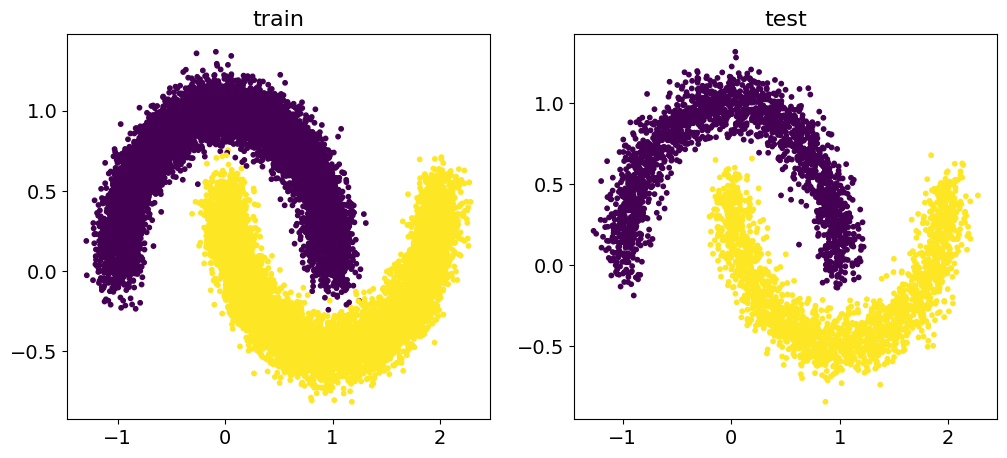

In [ ]:
COUNT = 20_000

train_data, train_labels, test_data, test_labels = load_dataset('moons', size=COUNT, with_targets=True)
visualize_2d_data(train_data, test_data, train_labels, test_labels)

Below you see the utility function, which broadcasts tensors. Look carefully at this code, we will use it in the majority of methods.

In [ ]:
def extract_into_tensor(
    arr: torch.Tensor,
    indices: torch.Tensor,
    broadcast_shape: torch.Size
) -> torch.Tensor:
    """
    Extract values from a 1-D torch tensor for a batch of indices.
    :param arr: 1-D torch tensor.
    :param timesteps: a tensor of indices to extract from arr.
    :param broadcast_shape: a larger shape of K dimensions with the batch
                            dimension equal to the length of timesteps.
    :return: a tensor of shape [batch_size, 1, ...] where the shape has K dims.
    """
    assert len(arr.shape) == 1
    res = arr.to(device=indices.device)[indices].float()
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]


    return res.expand(broadcast_shape)

### Forward Diffusion

Let start with forward diffusion.

**Forward process** is defined as a posterior distribution $q(\mathbf{x}_{1:T}|\mathbf{x}_0)$.

It is a Markov chain, which consequently adds Gaussian noise to a given object $\mathbf{x}_0$.

At every step of this process the Gaussian noise is added with different magnitude, which is determined with a schedule of variances $\{\beta_1, ... \beta_T\}$.
If this schedule is chosen properly and T goes to infinity (or is large enough), we will converge to pure noise $\mathcal{N}(0, I)$.

Markov chain is defined by:
$$
 q(\mathbf{x}_t | \mathbf{x}_{t - 1}) = \mathcal{N}(\mathbf{x}_t | \sqrt{1 - \beta_t}\mathbf{x}_{t - 1}, \beta_t \mathbf{I}), \quad q(\mathbf{x}_{1:T}|\mathbf{x}_0) = \prod_{t = 1}^T q(\mathbf{x}_t | \mathbf{x}_{t - 1})
$$

In order to get $\mathbf{x}_t$ we have to compute $\mathbf{x}_1, ..., \mathbf{x}_{t - 1}$ iteratively.

Hopefully, due to the properties of the Gaussian distribution we can do it more efficiently.

Let's denote
$\alpha_t = 1- \beta_t$ и $\bar{\alpha}_t= \prod_{s = 1}^t\alpha_s$.
Then
$$
q(\mathbf{x}_t | \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t|\sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1-\bar{\alpha}_t) \mathbf{I}).
\tag{1}
$$

Here we could get very useful expression
$$
    \mathbf{x}_t = \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1-\bar{\alpha}_t} \cdot \boldsymbol{\epsilon}. \tag{2}
$$

Now we will create base class for diffusion (we will use it as a python base class for forward and backward diffusions).

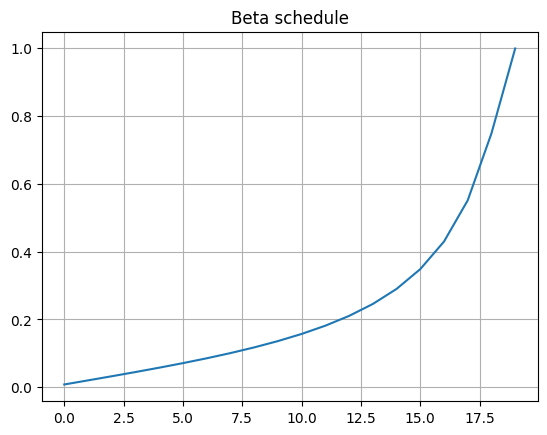

In [ ]:
class BaseDiffusion:
    def __init__(self, num_timesteps: int):
        self.num_timesteps = num_timesteps
        self.betas = self._get_beta_schedule(num_timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=-1)

    @staticmethod
    def _get_beta_schedule(num_diffusion_timesteps: int, s: float = 0.008):
        def f(t, T):
            return (np.cos((t / T + s) / (1 + s) * np.pi / 2)) ** 2

        alphas = []
        f0 = f(0, num_diffusion_timesteps)

        for t in range(num_diffusion_timesteps + 1):
            alphas.append(f(t, num_diffusion_timesteps) / f0)

        betas = []

        for t in range(1, num_diffusion_timesteps + 1):
            betas.append(min(1 - alphas[t] / alphas[t - 1], 0.999))

        return torch.from_numpy(np.array(betas)).double()


basediff = BaseDiffusion(num_timesteps=20)

plt.plot(basediff.betas.numpy())
plt.title('Beta schedule')
plt.grid()
plt.show()

We are ready to define forward diffusion process. It has 2 methods:
- to get mean and variance of the distribution $q(\mathbf{x}_t | \mathbf{x}_0)$,
- to get samples from this distribution.

In [ ]:
class ForwardDiffusion(BaseDiffusion):
    def get_mean_variance(self, x0: torch.Tensor, t: torch.Tensor):
        # ====
        # your code
        # calculate mean and variance of the distribution q(x_t | x_0) (use equation (1))
        # use extract_into_vatensor() function to get tensors of the same shape as x0
        abar_t = extract_into_tensor(self.alphas_cumprod, t, x0.shape)
        mean     = torch.sqrt(abar_t) * x0
        variance = 1 - abar_t
        # ====
        return mean, variance

    def get_samples(
        self,
        x0: torch.Tensor,
        t: torch.Tensor,
        noise: Optional[torch.Tensor] = None
    ):
        if noise is None:
            noise = torch.randn_like(x0)
        # ====
        # your code
        # sample from the distribution q(x_t | x_0) (use equation (2))
        mean, variance = self.get_mean_variance(x0, t)
        samples = mean + torch.sqrt(variance) * noise
        # ====
        return samples


def test_forward_diffusion():
    fdiff = ForwardDiffusion(num_timesteps=100)
    SHAPE = [2, 20]
    x0 = torch.ones(SHAPE)
    t = torch.ones((2,)).long() * 5
    mean, variance = fdiff.get_mean_variance(x0=x0, t=t)
    assert list(mean.shape) == SHAPE
    assert list(variance.shape) == SHAPE
    assert np.allclose(mean.numpy(), np.ones(SHAPE) * 0.9944681)
    assert np.allclose(variance.numpy(), np.ones(SHAPE) * 0.01103322)

    xt = fdiff.get_samples(x0=x0, t=t)
    assert list(xt.shape) == SHAPE

    noise = torch.ones(SHAPE)
    xt = fdiff.get_samples(x0=x0, t=t, noise=noise)
    assert np.allclose(xt.numpy(), np.ones(SHAPE) * 1.0995072)


test_forward_diffusion()

Let visualize the forward diffusion process. Here you have to see how the distribution of the real samples transforms to the Gaussian noise.

In [ ]:
# num_timesteps = 100

# fdiff = ForwardDiffusion(num_timesteps=num_timesteps)

# timestamps=[0, 2, 4, 10, 50]

# plot_n_steps = len(timestamps)
# for i, t in enumerate(timestamps):
#     x = fdiff.get_samples(x0=torch.from_numpy(train_data), t=torch.ones((train_data.shape[0], 1)).long() * t)
#     visualize_2d_samples(x, title=f"Step of diffusion: {t}", labels=train_labels)

### Reverse Diffusion

**Reverse process** consequently denoises pure Gaussian noise $\mathcal{N}(0, \mathbf{I})$ until we do not get the object from the original distribution $\pi(\mathbf{x})$.

It is a probability model with latent variables
$p(\mathbf{x}_0 | \boldsymbol{\theta}) := \int p(\mathbf{x}_{0:T} | \boldsymbol{\theta}) d\mathbf{x}_{1:T}$,
where
- latents $\mathbf{z} = \{\mathbf{x}_1, ..., \mathbf{x}_T\}$ correspond to noised objects
- $\mathbf{x}_0$ is an object from the original distribution $\pi(\mathbf{x})$.

Joint distribution $p(\mathbf{x}_{0:T} | \boldsymbol{\theta})$ is called reverse diffusion process, which is essentially a Markov chain of Gaussian distributions $p(\mathbf{x}_t|\mathbf{x}_t, \boldsymbol{\theta})$:
$$
p(\mathbf{x}_{0:T}) = p(\mathbf{x}_T) \prod_{t = 1}^T p(\mathbf{x}_{t-1}|\mathbf{x}_t, \boldsymbol{\theta}), \quad p(\mathbf{x}_{T} | \boldsymbol{\theta})=\mathcal{N}(0, \mathbf{I})
$$
$$
  p(\mathbf{x}_{t - 1}|\mathbf{x}_t | \boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\theta}, t}(\mathbf{x}_t), \boldsymbol{\sigma}^2_{\boldsymbol{\theta}, t}(\mathbf{x}_t)). \tag{3}
$$

In Lecture 9 we have derived ELBO for this model:

$$
    \mathcal{L}(q, \boldsymbol{\theta}) =  \mathbf{E}_{q} \Bigl[\log p(\mathbf{x}_0 | \mathbf{x}_1, \boldsymbol{\theta}) - KL\bigl(q(\mathbf{x}_T | \mathbf{x}_0) || p(\mathbf{x}_T)\bigr)
    - \sum_{t=2}^T \underbrace{KL \bigl(q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0) || p(\mathbf{x}_{t - 1} | \mathbf{x}_t, \boldsymbol{\theta} )\bigr)}_{\mathcal{L}_t} \Bigr].
$$

Here we use the following distribution $q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0) = \mathcal{N}( \boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0), \tilde{\beta}_t \mathbf{I}) $, where
$$
\boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0) = \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} \mathbf{x}_t + \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1 - \bar{\alpha}_t} \mathbf{x}_0
\tag{4}
$$
$$
\tilde{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \cdot \beta_t
\tag{5}
$$

(These scary formulas are not difficult to derive, follow the link to find details [Denoising Diffusion Probabilistic Models (Ho et al. 2020)](https://arxiv.org/abs/2006.11239)).

Now our goal is to define parameters $\boldsymbol{\mu}_{\boldsymbol{\theta}, t}(\mathbf{x}_t), \boldsymbol{\sigma}^2_{\boldsymbol{\theta}, t}(\mathbf{x}_t)$ of reverse diffusion.

#### Variance
Our first assumption is to set the variance $\boldsymbol{\sigma}^2_{\boldsymbol{\theta}, t}(\mathbf{x}_t) = \tilde{\beta}_t$. This is very native assumption

#### Mean
Here we will use the expression (2) to get $\mathbf{x}_0$ from $\mathbf{x}_t$:
$$
    \mathbf{x}_0 = \frac{\mathbf{x}_t - \sqrt{1 - \bar{\alpha}_{t}} \cdot \boldsymbol{\epsilon}}{\sqrt{\bar{\alpha}_{t}}}.
    \tag{6}
$$

If we put this expression to the formula (4) we will get:
$$
    \boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0) = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \cdot \boldsymbol{\epsilon} \right).
$$

So the idea here to parametrize the model mean in the same functional form:
$$
    \boldsymbol{\mu}_{\boldsymbol{\theta}, t}(\mathbf{x}_t) = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \cdot \boldsymbol{\epsilon}_{\boldsymbol{\theta}, t}(\mathbf{x}_t) \right).
$$

**Note:** our model will predict the noise which was applied to $\mathbf{x}_0$ to get $\mathbf{x}_t$.

In [ ]:
class ReverseDiffusion(BaseDiffusion):
    def __init__(self, *args, clip_range: Optional[Tuple[float, float]] = None, **kwargs):
        super().__init__(*args, **kwargs)
        self.clip_range = clip_range
        self.alphas_cumprod_prev = torch.cat(
            [torch.tensor([1.0], device=self.betas.device), self.alphas_cumprod[:-1]], dim=0
        )

        # ====
        # your code
        # calculate variance of the distribution q(x_{t-1} | x_t, x_0) (use equation (5))
        self.variance_q = (1 - self.alphas_cumprod_prev) / (1 - self.alphas_cumprod) * self.betas
        # ====

        # ====
        # your code
        # calculate coefficients of mean of the distribution q(x_{t-1} | x_t, x_0) (use equation (4))
        # mean = x_coef * x_t + x0_coef * x_0
        self.x_coef  = torch.sqrt(1 - self.betas) * (1 - self.alphas_cumprod_prev) / (1 - self.alphas_cumprod)
        self.x0_coef = torch.sqrt(self.alphas_cumprod_prev) * self.betas / (1 - self.alphas_cumprod)
        # ====

    def get_x0(self, xt: torch.Tensor, eps: torch.Tensor, t: torch.Tensor):
        # ====
        # your code
        # get x_0 (use equation (6))
        abar_t = extract_into_tensor(self.alphas_cumprod, t, xt.shape)
        x0 = (xt - torch.sqrt(1 - abar_t) * eps) / torch.sqrt(abar_t)
        # ====
        return x0.clamp(*self.clip_range) if self.clip_range is not None else x0

    def get_mean_variance(self, xt: torch.Tensor, eps: torch.Tensor, t: torch.Tensor):
        # ====
        # your code
        # get mean and variance of the distribution q(x_{t-1} | x_t, x_0) (use equations (4) and (5))
        # use get_x0 method to get x_0
        x_coef_t  = extract_into_tensor(self.x_coef,  t, xt.shape)
        x0_coef_t = extract_into_tensor(self.x0_coef, t, xt.shape)
        var_t     = extract_into_tensor(self.variance_q, t, xt.shape)
        mean = x_coef_t * xt + x0_coef_t * self.get_x0(xt, eps, t)
        # ====
        return mean, var_t

    def get_samples(self, xt: torch.Tensor, eps: torch.Tensor, t: torch.Tensor):
        # ====
        # your code
        # 1) get mean and variance of the distribution q(x_{t-1} | x_t, x_0)
        # 2) sample noise from the standard normal
        # 3) get samples using reparametrization trick
        mean, variance = self.get_mean_variance(xt, eps, t)
        sample = mean + torch.sqrt(variance) * torch.randn_like(xt)
        # ====
        return sample.float()


def test_reverse_diffusion():
    rdiff = ReverseDiffusion(num_timesteps=100)
    SHAPE = [2, 20]
    xt = torch.ones(SHAPE)
    eps = torch.ones(SHAPE)
    t = torch.ones((2,)).long() * 5

    x0 = rdiff.get_x0(xt=xt, eps=eps, t=t)
    assert list(x0.shape) == SHAPE
    assert np.allclose(x0.numpy(), np.ones(SHAPE) * 0.8999391)

    mean, variance = rdiff.get_mean_variance(xt=xt, eps=eps, t=t)
    assert list(mean.shape) == SHAPE
    assert list(variance.shape) == SHAPE
    assert np.allclose(mean.numpy(), np.ones(SHAPE) * 0.9723116)
    assert np.allclose(variance.numpy(), np.ones(SHAPE) * 0.00222036)

    x = rdiff.get_samples(xt, eps, t)
    assert list(x.shape) == SHAPE


test_reverse_diffusion()

### Model

In this task we will use simple MLP model to parametrize distribution $p(\mathbf{x}_{t-1} | \mathbf{x}_t, \boldsymbol{\theta})$. It will be conditioned on the timestamps.

In [ ]:
class ConditionalMLP(nn.Module):
    def __init__(self, input_dim: int, num_embeds: int, hidden_dim: int = 128):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.x_proj = nn.Linear(input_dim, self.hidden_dim)
        self.t_proj = nn.Embedding(num_embeds, self.hidden_dim)
        self.backbone = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.SELU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.SELU(),
            nn.Linear(self.hidden_dim, input_dim),
        )

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.x_proj(x)
        t = self.t_proj(t.int())
        x = x + t
        x = F.selu(x)
        return self.backbone(x)


def test_conditional_mlp():
    SHAPE = [2, 20]
    T = 100
    x = torch.ones(SHAPE)
    t = torch.ones((2,)).long() * 5
    model = ConditionalMLP(input_dim=20, num_embeds=100)
    output = model(x, t)
    assert list(output.shape) == SHAPE


test_conditional_mlp()

### DDPM

Let return to the ELBO. The main part of it is:
$$
    \mathcal{L}_t = KL \bigl(q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0) || p(\mathbf{x}_{t - 1} | \mathbf{x}_t, \boldsymbol{\theta} )\bigr)
$$

In Lecture 9 we have got that
$$
    \mathcal{L}_t = \mathbf{E}_{\boldsymbol{\epsilon}} \left[ \frac{\beta_t^2}{2 \tilde{\beta_t} \alpha_t (1 - \bar{\alpha}_t)} \| \boldsymbol{\epsilon} - \boldsymbol{\epsilon}_{\boldsymbol{\theta}, t}(\mathbf{x}_t) \|^2 \right].
$$

In practice this loss is simplified. Particilarly, we will omit coefficient of the norm and we will sample index $t$ at each training step.

Finally, we will train our model with the following objective:
$$
\text{loss} = \mathbf{E}_{\mathbf{x}_0, \boldsymbol{\epsilon}, t}\bigg[ \|\boldsymbol{\epsilon} - \boldsymbol{\epsilon}_{\boldsymbol{\theta}, t}(\mathbf{x}_t)\|^2\bigg],
$$
where $\mathbf{x}_t = \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t} \boldsymbol{\epsilon}$.

The following class implements two methods:
- `loss` - to compute the loss at the training step;
- `sample` - to sample from the final model.

In [ ]:
class DDPM(BaseModel):
    def __init__(self, num_timesteps: int, model: nn.Module):
        super().__init__()

        self.num_timesteps = num_timesteps

        self.forward_diffusion = ForwardDiffusion(num_timesteps=num_timesteps)
        self.reverse_diffusion = ReverseDiffusion(num_timesteps=num_timesteps)
        self.model = model
        self.shape = None

    @torch.no_grad()
    def sample(self, num_samples: int):
        assert self.shape is not None
        x = torch.randn((num_samples, *self.shape), device=self.device, dtype=torch.float32)
        indices = list(range(self.num_timesteps))[::-1]

        for i in indices:
            t = torch.tensor([i] * num_samples, device=x.device)
            # ====
            # your code
            # 1) get epsilon from the model
            # 2) sample from the reverse diffusion
            epsilon = self.model(x, t)
            x = self.reverse_diffusion.get_samples(x, epsilon, t)
            # ====
        return x

    def loss(self, x0: torch.Tensor):
        if self.shape is None:
            self.shape = list(x0.shape)[1:]
        t = torch.randint(0, self.num_timesteps, size=(x0.size(0),), device=x0.device)
        noise = torch.randn_like(x0)

        # ====
        # your code
        # 1) get x_t
        # 2) get epsilon from the model
        # 3) compute mse loss between epsilon and noise
        xt = self.forward_diffusion.get_samples(x0, t, noise)
        epsilon = self.model(xt, t)
        loss = torch.nn.functional.mse_loss(noise, epsilon)
        # ====
        return {"total_loss": loss}

### Training

Now we are ready to train our model.

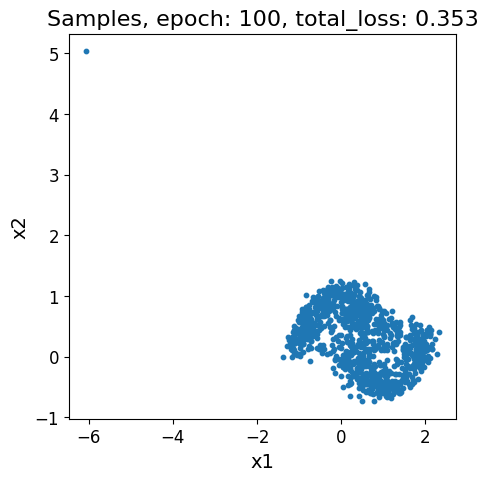

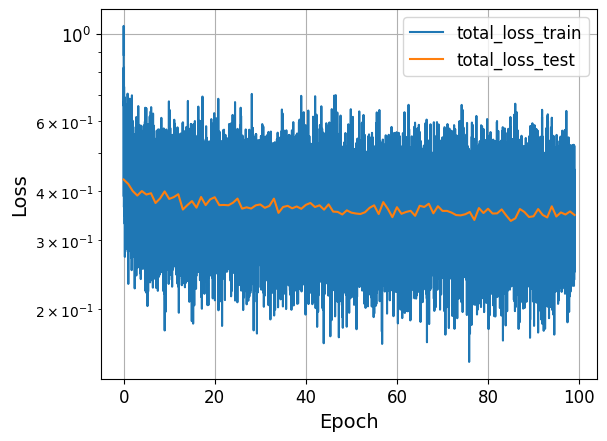

End of the training


In [ ]:
# ====
# your code
# choose these parameters
BATCH_SIZE = 64
LR = 0.0005
EPOCHS = 100
T = 100
# ====

model = ConditionalMLP(input_dim=2, num_embeds=T)
ddpm = DDPM(num_timesteps=T, model=model)

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# try your own optimizer/scheduler
optimizer = torch.optim.AdamW(ddpm.parameters(), lr=LR, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)

train_model(
    ddpm,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    optimizer=optimizer,
    scheduler=scheduler,
    device=DEVICE,
    n_samples=1024,
    visualize_samples=True,
    logscale_y=True,
)

Now let's sample from our trained model.

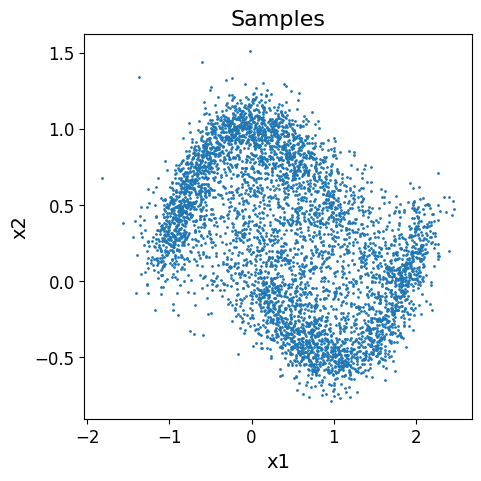

In [ ]:
samples = ddpm.sample(num_samples=5000).cpu()

visualize_2d_samples(samples, title="Samples", s=1)

Now let's see how denoising looks like (similarly to forward noising process).

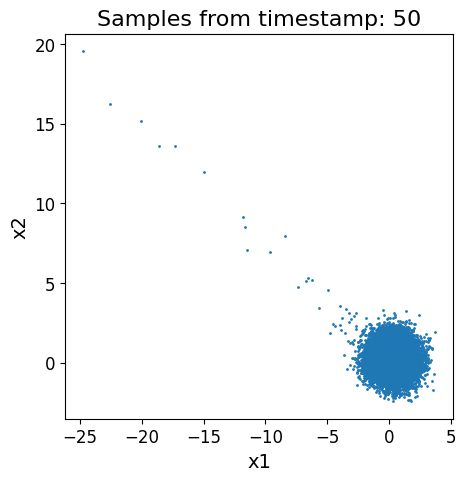

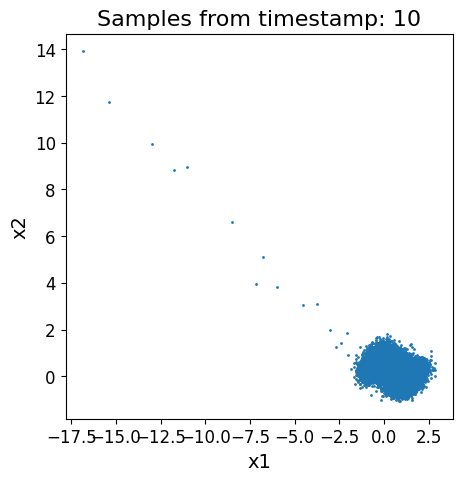

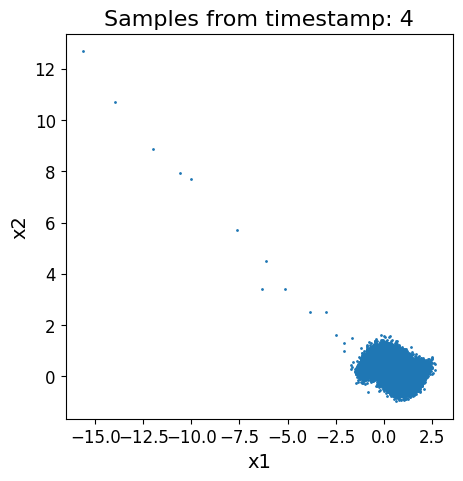

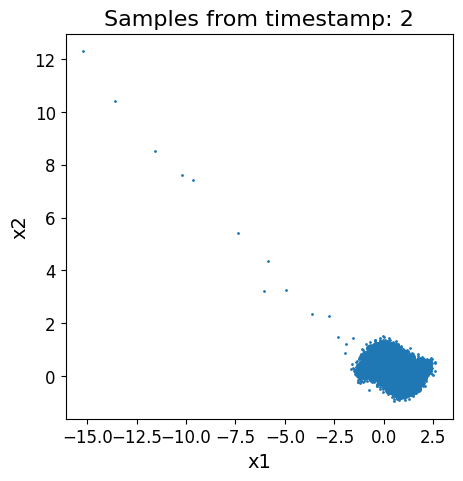

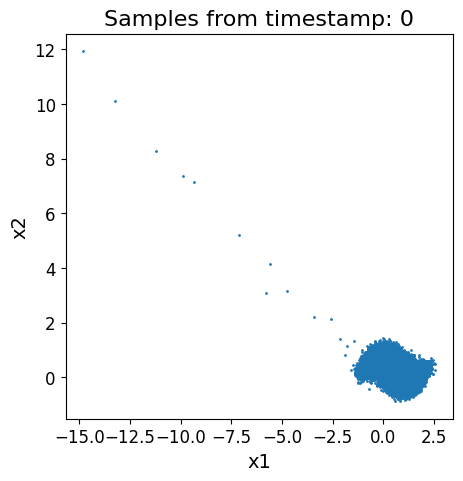

In [ ]:
timestamps=[0, 2, 4, 10, 50]

x = torch.randn(train_data.shape[0], 2, requires_grad=False).to(ddpm.device)
for i in range(ddpm.num_timesteps - 1, -1, -1):
    t = torch.tensor(i, dtype=torch.long, requires_grad=False).expand(x.shape[0]).to(ddpm.device)
    with torch.no_grad():
        eps = ddpm.model(x, t)
        x = ddpm.reverse_diffusion.get_samples(xt=x, eps=eps, t=t)
    if i in reversed(timestamps):
        x_ = x.cpu()
        visualize_2d_samples(x_, title=f"Samples from timestamp: {i}", s=1)

## Task3: DDPM on MNIST with guidance (5pt)

Let apply our diffusion model to the MNIST dataset with classifier-free guidance.

In [ ]:
train_data, train_labels, test_data, test_labels = load_dataset("mnist", flatten=False, binarize=False, with_targets=True)
visualize_images(train_data, "MNIST samples")

Let's take a look at the forward process for the MNIST images.

In [ ]:
num_timesteps = 1000

fdiff = ForwardDiffusion(num_timesteps=num_timesteps)

timestamps=[0, 50, 100, 200, 300, 500, 600, 800, 999]

plot_n_steps = len(timestamps)
samples = []
x0 = train_data[10:11]
x0 = 2 * x0 - 1
for i, t in enumerate(timestamps):
    x = fdiff.get_samples(x0=torch.from_numpy(x0), t=torch.ones((x0.shape[0], 1)).long() * t)
    samples.append(x.cpu().numpy())

samples = np.concatenate(samples)
samples = (0.5 * samples + 0.5).clip(0, 1)
show_samples(samples, title="Noisy samples", nrow=len(timestamps), figsize=(20, 2))

As in Seminar 8 we will use UNet - a standart choice for diffusion models. The model will be mostly implemented, but you could change it if you want.

First, we'll define embedding layers for our UNet architecture. In diffusion models with guidance, we usually embed both timesteps and conditional information:

1. `TimeEmbedding` - creates sinusoidal position embeddings for timesteps, allowing the model to understand which diffusion step it's processing.
2. `ConditionalEmbedding` - creates embeddings for class labels, enabling classifier-free guidance where we can condition the generation on specific classes.

In [ ]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class TimeEmbedding(nn.Module):
    def __init__(self, T, dim_in, dim_out):
        super().__init__()
        assert dim_in % 2 == 0
        emb = torch.arange(0, dim_in, step=2) / dim_in * math.log(10000)
        emb = torch.exp(emb)
        pos = torch.arange(T).float()
        emb = pos[:, None] * emb[None, :]
        assert list(emb.shape) == [T, dim_in // 2]
        emb = torch.stack([torch.sin(emb), torch.cos(emb)], dim=-1)
        assert list(emb.shape) == [T, dim_in // 2, 2]
        emb = emb.view(T, dim_in)

        self.time_embedding = nn.Sequential(
            nn.Embedding.from_pretrained(emb),
            nn.Linear(dim_in, dim_out),
            Swish(),
            nn.Linear(dim_out, dim_out)
        )

        self.initialize()

    def initialize(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_normal_(module.weight)
                torch.nn.init.zeros_(module.bias)

    def forward(self, t):
        emb = self.time_embedding(t)
        return emb

class ConditionalEmbedding(nn.Module):
    def __init__(self, num_labels, dim_in, dim_out):
        assert dim_in % 2 == 0
        super().__init__()
        self.condition_embedding = nn.Sequential(
            nn.Embedding(num_embeddings=num_labels+1, embedding_dim=dim_in, padding_idx=0),
            nn.Linear(dim_in, dim_out),
            Swish(),
            nn.Linear(dim_out, dim_out),
        )

    def forward(self, cond):
        emb = self.condition_embedding(cond)
        return emb

The UNet's core component is the `ResBlock`, which enhances standard ResNet blocks with time step and conditional inputs embeddings and optional attention mechanism.

In [ ]:
class AttnBlock(nn.Module):
    def __init__(self, in_dim: int):
        super().__init__()
        self.group_norm = nn.GroupNorm(32, in_dim)
        self.proj_q = nn.Conv2d(in_dim, in_dim, kernel_size=1, stride=1, padding=0)
        self.proj_k = nn.Conv2d(in_dim, in_dim, kernel_size=1, stride=1, padding=0)
        self.proj_v = nn.Conv2d(in_dim, in_dim, kernel_size=1, stride=1, padding=0)
        self.proj = nn.Conv2d(in_dim, in_dim, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.group_norm(x)
        q = self.proj_q(h)
        k = self.proj_k(h)
        v = self.proj_v(h)

        q = q.permute(0, 2, 3, 1).view(B, H * W, C)
        k = k.view(B, C, H * W)
        w = torch.bmm(q, k) * (int(C) ** (-0.5))
        assert list(w.shape) == [B, H * W, H * W]
        w = F.softmax(w, dim=-1)

        v = v.permute(0, 2, 3, 1).view(B, H * W, C)
        h = torch.bmm(w, v)
        assert list(h.shape) == [B, H * W, C]
        h = h.view(B, H, W, C).permute(0, 3, 1, 2)
        h = self.proj(h)

        return x + h


class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, t_dim, dropout, attn=False):
        super().__init__()

        self.temb_proj = nn.Sequential(Swish(), nn.Linear(t_dim, out_channels))
        self.cemb_proj = nn.Sequential(Swish(), nn.Linear(t_dim, out_channels))

        # ====
        # your code
        # create two convolutional blocks of nn.Sequential
        # first block should take raw input
        # second block should take the output of the first block with added time and class embeddings
        # it is preferrable to use nn.GroupNorm, Swish and nn.Dropout

        # ====

        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()
        self.attn = AttnBlock(out_channels) if attn else nn.Identity()


    def forward(self, x, temb, labels):
        # ====
        # your code
        # 1) pass x through the first block
        # 2) add time and class embeddings (unsqueeze them to the right shape)
        # 3) pass the result through the second block
        # 4) add the shortcut
        # 5) pass the result through the attention block

        # ====
        return h

The `DownsampleBlock` and `UpsampleBlock` implement the UNet's characteristic encoder-decoder structure, managing resolution changes as features flow through the network.

In [ ]:
class DownsampleBlock(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        # ====
        # your code
        # define convolutional layer that:
        # 1) does not change the number of channels
        # 2) reduces the size of the image twice

        # ====

    def forward(self, input_tensor: torch.Tensor, *args) -> torch.Tensor:
        # ====
        # your code

        # ====
        return x

class UpsampleBlock(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        # ====
        # your code
        # define convolutional layer that:
        # 1) does not change the number of channels
        # 2) does not reduce the size of the image

        # ====

    def forward(self, input_tensor: torch.Tensor, *args) -> torch.Tensor:
        # ====
        # your code
        # 1) upsample the input tensor using bilinear interpolation
        # 2) pass the result through the convolutional layer

        # ====
        return x

Finally, we define the complete `UNet` - the neural network backbone of our diffusion model that handles both encoding and decoding with skip connections. Look at the code carefully.

In [ ]:
class UNet(nn.Module):
    def __init__(
        self,
        num_timesteps: int,
        num_labels: int,
        hidden_channels: int,
        channel_multipliers: List[int],
        num_blocks: int = 1,
        dropout: float = 0.1
    ):
        super().__init__()

        temb_dim = hidden_channels * 4
        self.time_embedding = TimeEmbedding(num_timesteps, hidden_channels, temb_dim)
        self.cond_embedding = ConditionalEmbedding(num_labels, hidden_channels, temb_dim)
        self.head = nn.Conv2d(1, hidden_channels, kernel_size=3, stride=1, padding=1)
        channel_list, curr_channels = [hidden_channels], hidden_channels

        # initialization of downsample blocks
        self.downsample_blocks = nn.ModuleList()
        for idx, scale in enumerate(channel_multipliers):
            out_channels = hidden_channels * scale
            is_last = (idx == len(channel_multipliers) - 1)

            # make multiple ResBlocks at each scale
            for _ in range(num_blocks):
                # at each channel_multipliers scale we add ResBlock
                # last block has attention
                self.downsample_blocks.append(
                    ResBlock(curr_channels, out_channels, temb_dim, dropout, attn=True)
                )
                curr_channels = out_channels
                channel_list.append(curr_channels)

            # add downsample block if not last block
            if not is_last:
                self.downsample_blocks.append(DownsampleBlock(curr_channels))
                channel_list.append(curr_channels)

        # initialization of bottleneck block
        self.bottleneck = nn.ModuleList([
            ResBlock(curr_channels, curr_channels, temb_dim, dropout, attn=True),
            ResBlock(curr_channels, curr_channels, temb_dim, dropout, attn=False)
        ])

        # initialization of upsample blocks
        self.upsample_blocks = nn.ModuleList()
        for idx, scale in reversed(list(enumerate(channel_multipliers))):
            out_channels = hidden_channels * scale
            is_first, is_last = (idx == 0), (idx == len(channel_multipliers) - 1)

            # make multiple ResBlocks at each scale
            for _ in range(num_blocks + 1):
                # at each reverse channel_multipliers scale we add ResBlock
                # first block has attention
                self.upsample_blocks.append(
                    ResBlock(channel_list.pop() + curr_channels, out_channels, temb_dim, dropout, attn=False)
                )

                curr_channels = out_channels

            # add upsample block if not last block
            if not is_first:
                self.upsample_blocks.append(UpsampleBlock(curr_channels))

        self.tail = nn.Sequential(
            nn.GroupNorm(32, curr_channels),
            Swish(),
            nn.Conv2d(curr_channels, 1, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x, t, y=None):
        temb = self.time_embedding(t)
        cemb = torch.zeros_like(temb) if y is None else self.cond_embedding(y)

        h = self.head(x)
        skip_connections = [h] # save intermediate results for skip connections

        # downsample
        for layer in self.downsample_blocks:
            h = layer(h, temb, cemb)
            skip_connections.append(h) # save intermediate results for skip connections

        # bottleneck
        for layer in self.bottleneck:
            h = layer(h, temb, cemb)

        # upsample
        for layer in self.upsample_blocks:
            if isinstance(layer, ResBlock): # apply skip connection
                skip_connection = skip_connections.pop()
                h = torch.cat([h, skip_connection], dim=1)
            h = layer(h, temb, cemb)

        h = self.tail(h)
        return h

def test_unet():
    model = UNet(
        num_timesteps=10,
        num_labels=10,
        hidden_channels=128,
        channel_multipliers=[1, 2, 4],
    )
    x = torch.rand((2, 1, 32, 32))
    y = torch.zeros(size=(2,), dtype=torch.long)
    t = torch.zeros(size=(2,), dtype=torch.long)
    out1 = model(x, t, y)
    t = torch.ones(size=(2,), dtype=torch.long)
    out2 = model(x, t, y)
    assert not np.allclose(out1.detach().numpy(), out2.detach().numpy())


test_unet()

Here we again implement the class of DDPM but now that can handle classifier-free guidance.

From Lecture 10 we know that to train DDPM with classifier-free guidance we train the single model $\mathbf{\epsilon}_{\theta, t}(\mathbf{x_t}, \mathbf{y})$ alternating with real conditioning $\mathbf{y}$ and empty conditioning $\mathbf{y} = \emptyset$. Then we apply twice the model to make one denoising step:

$$
    \mathbf{x_{t-1}} = \frac{1}{\sqrt{\alpha_t}} \cdot \mathbf{x_t} - \frac{1 - \alpha_t}{\sqrt{\alpha_t (1 - \bar{\alpha}_t)}} \cdot  \hat{\mathbf{\epsilon}}_{\theta, t}(\mathbf{x_t}, \mathbf{y}) + \sigma_t \cdot \mathbf{\epsilon},
$$
where:
$$
    \hat{\mathbf{\epsilon}}_{\theta, t}(\mathbf{x_t}, \mathbf{y}) = \gamma \cdot \mathbf{\epsilon}_{\theta, t}(\mathbf{x_t}, \mathbf{y}) + (1 - \gamma) \cdot \mathbf{\epsilon}_{\theta, t}(\mathbf{x_t}, \emptyset).
$$

**Note 1:** To use UNet in unconditional way use the argument `y = None` (see `UNet.forward`).

**Note 2:** We scale the data and clamp final samples $x_0$ to $[-1, 1]$.

In [ ]:
class ConditionalDDPM(BaseModel):
    def __init__(self, num_timesteps: int, model: nn.Module):
        super().__init__()

        self.num_timesteps = num_timesteps
        self.forward_diffusion = ForwardDiffusion(num_timesteps=num_timesteps)
        self.reverse_diffusion = ReverseDiffusion(num_timesteps=num_timesteps, clip_range=(-1.0, 1.0))
        self.model = model
        self.shape = None

    @torch.no_grad()
    def sample(self, num_samples: int, y=None, guidance_scale: float = 3.0):
        assert self.shape is not None
        x = torch.randn((num_samples, *self.shape), device=self.device, dtype=torch.float32)
        indices = list(range(self.num_timesteps))[::-1]

        for i in indices:
            t = torch.tensor([i] * num_samples, device=x.device)
            # ====
            # your code
            # 1) get epsilon from the model without conditioning
            # 2) if y is not None then
            #    get epsilon from the model with conditioning
            #    modify epsilon with classifier-free guidance formula
            # 3) sample from the reverse diffusion

            # ====
        return torch.clamp(0.5 * x + 0.5, 0.0, 1.0)

    def loss(self, x0, y=None):
        x0 = 2.0 * x0 - 1.0
        if self.shape is None:
            self.shape = list(x0.shape)[1:]

        t = torch.randint(0, self.num_timesteps, size=(x0.shape[0],), device=x0.device)
        noise = torch.randn_like(x0)
        # ====
        # your code
        # 1) get x_t
        # 2) get epsilon from the model
        # 3) compute mse loss between epsilon and noise
        # NOTE: here you just pass y to the model

        # ====
        return {"total_loss": loss}

That is all. We are ready to train our **unconditional** model.

In [ ]:
# ====
# your code
# choose these parameters
BATCH_SIZE =
LR =
EPOCHS =
HIDDEN_CHANNELS =
CHANNEL_MULTIPLIERS =
NUM_BLOCKS =
T =
# ====

cond_model = UNet(
    num_timesteps=T,
    num_labels=10,
    hidden_channels=HIDDEN_CHANNELS,
    channel_multipliers=CHANNEL_MULTIPLIERS,
    num_blocks=NUM_BLOCKS
)
cond_ddpm = ConditionalDDPM(num_timesteps=T, model=cond_model)

# try your own optimizer/scheduler
optimizer = torch.optim.AdamW(cond_ddpm.parameters(), lr=LR, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)

# train unconditional mode
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
train_model(
    cond_ddpm,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    optimizer=optimizer,
    scheduler=scheduler,
    conditional=False,
    device=DEVICE,
    n_samples=16,
    visualize_samples=True, # prabably you would like to turn this off
    logscale_y=True,
)
# to save your time you can save the model
# torch.save(cond_ddpm.state_dict(), "unconditional_ddpm.pth")

Let's draw samples from the trained unconditional model.

In [ ]:
cond_ddpm.eval()
cond_ddpm = cond_ddpm.to(DEVICE)

num_samples = 100
y = None
samples = cond_ddpm.sample(num_samples=num_samples, y=y).cpu().numpy()
show_samples(samples, title="Samples")

Now lets fine-tune our unconditional model on samples with lables to make it **conditional**.

In [ ]:
# ====
# your code
# choose these parameters
BATCH_SIZE =
LR =
EPOCHS =
HIDDEN_CHANNELS =
CHANNEL_MULTIPLIERS =
NUM_BLOCKS =
T =
# ====

# you can load the model with this code
# cond_model = UNet(
#     num_timesteps=T,
#     num_labels=10,
#     hidden_channels=HIDDEN_CHANNELS,
#     channel_multipliers=CHANNEL_MULTIPLIERS,
#     num_blocks=NUM_BLOCKS
# )
# cond_ddpm = ConditionalDDPM(num_timesteps=T, model=cond_model)
# cond_ddpm.load_state_dict(torch.load("unconditional_ddpm.pth"))

# optimizer = torch.optim.AdamW(cond_ddpm.parameters(), lr=LR, weight_decay=0.0001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)

# train conditional mode
train_loader = data.DataLoader(LabeledDataset(train_data, train_labels), batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(LabeledDataset(test_data, test_labels), batch_size=BATCH_SIZE, shuffle=False)
train_model(
    cond_ddpm,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    optimizer=optimizer,
    conditional=True,
    device=DEVICE,
    n_samples=16,
    visualize_samples=True,  # prabably you would like to turn this off
    logscale_y=True,
)

Let's draw samples with guidance.

In [ ]:
cond_ddpm.eval()
cond_ddpm = cond_ddpm.to(DEVICE)

num_samples = 100
y = (torch.arange(num_samples) % 10).to(DEVICE)
samples = cond_ddpm.sample(num_samples=num_samples, y=y).cpu().numpy()
show_samples(samples, title="Samples")